In [1]:
#create config
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    image_size = 256  # TODO: the generated image resolution
    channels = 1 
    train_batch_size = 4
    eval_batch_size = 4
    num_epochs = 80 #600
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 100 #500
    evaluate_epochs = 20 #30
    save_model_epochs = 60 # 300
    mixed_precision = "fp16"  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = "lesion-filling-256-cond-circle"  # the model name locally and on the HF Hub
    dataset_train_path = "./dataset_train/imgs"
    segm_train_path = "./dataset_train/segm"
    dataset_eval_path = "./dataset_eval/imgs"
    segm_eval_path = "./dataset_eval/segm"
    num_gpu=2
    debug=True
    num_inference_steps=50
    #uniform_dataset_path = "./uniform_dataset"

    push_to_hub = False  # whether to upload the saved model to the HF Hub
    #hub_model_id = "<your-username>/<my-awesome-model>"  # the name of the repository to create on the HF Hub
    #hub_private_repo = False
    #overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0
config = TrainingConfig()

In [ ]:
if config.debug:
    config.num_inference_steps=5
    config.train_batch_size = 1
    config.eval_batch_size = 1

In [2]:
#setup huggingface accelerate
import accelerate
accelerate.commands.config.default.write_basic_config(config.mixed_precision)

#setup tensorboard
import torch
from torch.utils.tensorboard import SummaryWriter
tb_summary = SummaryWriter(config.output_dir, purge_step=0)

Configuration already exists at /home/jovyan/.cache/huggingface/accelerate/default_config.yaml, will not override. Run `accelerate config` manually or pass a different `save_location`.


2024-03-19 10:11:51.308719: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-19 10:11:51.400191: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-19 10:11:51.400242: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-19 10:11:51.400305: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-19 10:11:51.415524: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-19 10:11:51.419772: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [3]:
#log at tensorboard
tb_summary.add_scalar("image_size", config.image_size, 0)
tb_summary.add_scalar("train_batch_size", config.train_batch_size, 0)
tb_summary.add_scalar("eval_batch_size", config.eval_batch_size, 0)
tb_summary.add_scalar("num_epochs", config.num_epochs, 0)
tb_summary.add_scalar("learning_rate", config.learning_rate, 0)
tb_summary.add_scalar("lr_warmup_steps", config.lr_warmup_steps, 0)
tb_summary.add_scalar("evaluate_epochs", config.evaluate_epochs, 0)
tb_summary.add_text("mixed_precision", config.mixed_precision, 0) 

In [7]:
# create dataset
from torch.utils.data import Dataset
from torch.nn import functional as F
from pathlib import Path
import nibabel as nib
import numpy as np
from math import floor, ceil

class DatasetMRI(Dataset):
    """
    Dataset for Training purposes. 
    Adapted implementation of BraTS 2023 Inpainting Challenge (https://github.com/BraTS-inpainting/2023_challenge).
    
    Contains ground truth t1n images (gt) 
    Args:
        root_dir_img: Path to img files
        root_dir_segm: Path to segmentation maps
        pad_shape: Shape the images will be transformed to

    Raises:
        UserWarning: When your input images are not (256, 256, 160)

    Returns: 
        __getitem__: Returns a dictoinary containing:
            "gt_image": Padded and cropped version of t1n 2D slice
            "segm": Segmentation of 2D slice
            "t1n_path": Path to the unpadded t1n file for this sample
            "max_v": Maximal value of t1 image (used for normalization)
            
    """

    def __init__(self, root_dir_img: Path, root_dir_segm: Path, pad_shape=(256,256,256), only_white_matter=False):
        #Initialize variables
        self.root_dir_img = root_dir_img
        self.root_dir_segm = root_dir_segm
        self.pad_shape = pad_shape 
        self.list_paths_t1n = list(root_dir_img.rglob("*.nii.gz"))
        self.list_paths_segm = list(root_dir_segm.rglob("*.nii.gz"))
        #define offsets between first and last segmented slices and the slices to be used for training
        bottom_offset=60
        top_offset=20

        #go through all 3D imgs
        idx=0
        self.idx_to_2D_slice = dict()
        for j, path in enumerate(self.list_paths_segm):
            t1n_segm = nib.load(path)
            t1n_3d = t1n_segm.get_fdata()

            #transform segmentation
            t1n_3d = np.transpose(t1n_3d)
            t1n_3d = np.flip(t1n_3d, axis=1)

            #get first slice with white matter or segmented content plus offset
            i=0
            if(only_white_matter):
                #while there is no white matter go to the next slide
                while(not np.logical_or(t1n_3d[:,i,:]==41, t1n_3d[:,i,:]==2).any()):
                    i += 1
                bottom = i
            else:
                #while there is no segmented tissue go to the next slide
                while(not t1n_3d[:,i,:].any()):
                    i += 1
                bottom = i + bottom_offset 

            #get last slice with white matter or segmented content minus offset
            i=t1n_3d.shape[1]-1
            if(only_white_matter):
                while(not np.logical_or(t1n_3d[:,i,:]==41, t1n_3d[:,i,:]==2).any()):
                    i -= 1
                top = i
            else:
                while(not t1n_3d[:,i,:].any()):
                    i -= 1
                top = i - top_offset 
            
            #Add all slices between desired top and bottom slice to dataset
            for i in np.arange(top-bottom):
                self.idx_to_2D_slice[idx]=(self.list_paths_t1n[j], self.list_paths_segm[j],bottom+i, [])
                idx+=1   

    def __len__(self): 
        return len(self.idx_to_2D_slice.keys()) 

    def preprocess(self, t1n: np.ndarray):
        """
        Transforms the images to a more unified format.
        Normalizes to -1,1. Pad and crop to bounding box.
        
        Args:
            t1n (np.ndarray): t1n from t1n file (ground truth).

        Raises:
            UserWarning: When your input images are not (256, 256, 160)

        Returns:
            t1n: The padded and cropped version of t1n.
            t1n_max_v: Maximal value of t1n image (used for normalization).
        """

        #Size assertions
        reference_shape = (256,256,160)
        if t1n.shape != reference_shape:
            raise UserWarning(f"Your t1n shape is not {reference_shape}, it is {t1n.shape}")

        #Normalize the image to [0,1]
        t1n[t1n<0] = 0 #Values below 0 are considered to be noise #TODO: Check validity
        t1n_max_v = np.max(t1n)
        t1n /= t1n_max_v

        #pad to bounding box
        size = self.pad_shape # shape of bounding box is (size,size,size) #TODO: Find solution for 2D
        t1n = torch.Tensor(t1n)
        d, w, h = t1n.shape[-3], t1n.shape[-2], t1n.shape[-1]
        d_max, w_max, h_max = size
        d_pad = max((d_max - d) / 2, 0)
        w_pad = max((w_max - w) / 2, 0)
        h_pad = max((h_max - h) / 2, 0)
        padding = (
            int(floor(h_pad)),
            int(ceil(h_pad)),
            int(floor(w_pad)),
            int(ceil(w_pad)),
            int(floor(d_pad)),
            int(ceil(d_pad)),
        )
        t1n = F.pad(t1n, padding, value=0, mode="constant") 

        #map images from [0,1] to [-1,1]
        t1n = (t1n*2) - 1

        return t1n, t1n_max_v

    def __getitem__(self, idx):
        t1n_path = self.idx_to_2D_slice[idx][0]
        segm_path = self.idx_to_2D_slice[idx][1]
        slice_idx = self.idx_to_2D_slice[idx][2]
        masks = self.idx_to_2D_slice[idx][3]
        
        t1n_img = nib.load(t1n_path)
        t1n = t1n_img.get_fdata()
        t1n_segm = nib.load(segm_path)
        t1n_segm_data = t1n_segm.get_fdata()
        
        t1n_segm_data = np.transpose(t1n_segm_data)
        t1n_segm_data = np.flip(t1n_segm_data, axis=1)
        
        # preprocess data
        t1n, t1n_max_v = self.preprocess(t1n)
        
        # get 2D slice from 3D
        t1n_slice = t1n[:,slice_idx,:] 
        t1n_segm_slice = t1n_segm_data[:,slice_idx,:]
        
        # Output data
        sample_dict = {
            "gt_image": t1n_slice.unsqueeze(0),
            "segm": t1n_segm_slice,
            "t1n_path": str(t1n_path),  # path to the 3D t1n file for this sample.
            "max_v": t1n_max_v,  # maximal t1n_voided value used for normalization
            "masks": masks, #generated masks
        }
        return sample_dict 

In [5]:
"""
def generate_white_matter_masks(segm, device, generator=None):
    n=segm.shape[0]

    center = torch.empty(size=n)
    for i in torch.arange(n):
        #get indices with white matter
        wm_idx = torch.nonzero(segm[i])
        #take random white matter idx as center
        center[i] = torch.randint(low=0, high=wm_idx.shape[0], size=1, device=device, generator=generator)

    low=3   
    high=40
    radius=torch.rand(n, device=device, generator=generator)*(high-low)+low # get radius between 3 and 40 from uniform distribution 


    #samplen eines radius und schauen ob 70% white matter ist
    #falls nicht, dann radius um die hälfte verkleinern
    #wiederholen bis mindestgrösse erreicht und falls wieder nicht, dann neuer radius samplen
    
    
    

    
    
    

    #Test case
    #center=torch.tensor([[0,255],[0,255]]) 
    #radius=torch.tensor([2,2])
    
    Y, X = [torch.arange(config.image_size, device=device)[:,None],torch.arange(config.image_size, device=device)[None,:]] # gives two vectors, each containing the pixel locations. There's a column vector for the column indices and a row vector for the row indices.
    dist_from_center = torch.sqrt((X.T - center[:,0])[None,:,:]**2 + (Y-center[:,1])[:,None,:]**2) # creates matrix with euclidean distance to center
    dist_from_center = dist_from_center.permute(2,0,1) 

    #Test case
    #print(dist_from_center[0,0,0]) #=255
    #print(dist_from_center[0,0,255]) #=360.624
    #print(dist_from_center[0,255,0]) #=0
    #print(dist_from_center[0,255,255]) #=255
    #print(dist_from_center[0,127,127]) #=180.313 
    
    masks = dist_from_center > radius[:,None,None] # creates mask for pixels which are outside the radius. 
    masks = masks[:,None,:,:].int() 
    return masks
"""

"\ndef generate_white_matter_masks(segm, device, generator=None):\n    n=segm.shape[0]\n\n    center = torch.empty(size=n)\n    for i in torch.arange(n):\n        #get indices with white matter\n        wm_idx = torch.nonzero(segm[i])\n        #take random white matter idx as center\n        center[i] = torch.randint(low=0, high=wm_idx.shape[0], size=1, device=device, generator=generator)\n\n    low=3   \n    high=40\n    radius=torch.rand(n, device=device, generator=generator)*(high-low)+low # get radius between 3 and 40 from uniform distribution \n\n\n    #samplen eines radius und schauen ob 70% white matter ist\n    #falls nicht, dann radius um die hälfte verkleinern\n    #wiederholen bis mindestgrösse erreicht und falls wieder nicht, dann neuer radius samplen\n    \n    \n    \n\n    \n    \n    \n\n    #Test case\n    #center=torch.tensor([[0,255],[0,255]]) \n    #radius=torch.tensor([2,2])\n    \n    Y, X = [torch.arange(config.image_size, device=device)[:,None],torch.arange(conf

In [24]:
#create dataset
datasetTrain = DatasetMRI(Path(config.dataset_train_path), Path(config.segm_train_path), pad_shape=(256, 256, 256), only_white_matter=True)
datasetEvaluation = DatasetMRI(Path(config.dataset_eval_path), Path(config.segm_eval_path), pad_shape=(256, 256, 256))

print(f"Dataset size: {len(datasetTrain)}")
print(f"\tImage shape: {datasetTrain[0]['gt_image'].shape}")
print(f"Training Data: {list(datasetTrain[0].keys())}") 

Dataset size: 113
	Image shape: torch.Size([1, 256, 256])
Training Data: ['gt_image', 'segm', 't1n_path', 'max_v', 'masks']


### Visualize dataset

<bound method Figure.show of <Figure size 1600x400 with 2 Axes>>

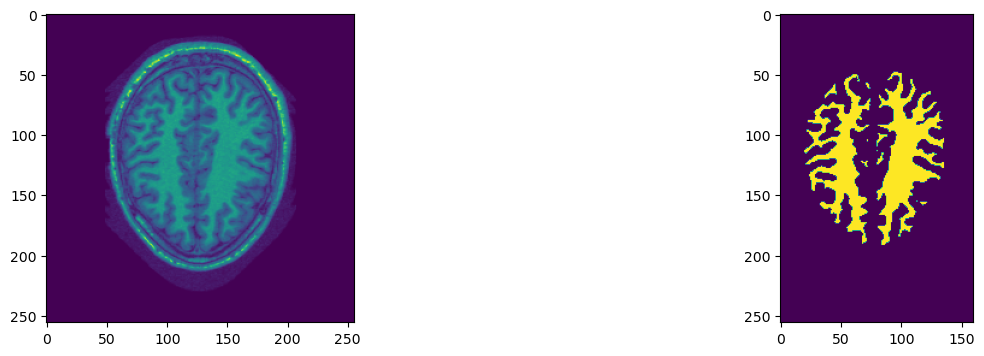

In [9]:
import matplotlib.pyplot as plt
fig, axis = plt.subplots(1,2,figsize=(16,4))
idx=80
axis[0].imshow((datasetTrain[idx]["gt_image"].squeeze()+1)/2)
axis[1].imshow(np.logical_or(datasetTrain[idx]["segm"].squeeze()==41, datasetTrain[idx]["segm"].squeeze()==2))
fig.show 

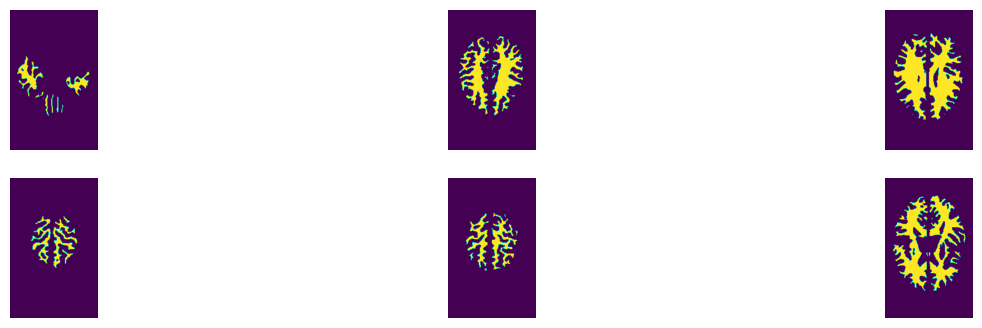

In [10]:
# Get 6 random sample
random_indices = np.random.randint(0, len(datasetTrain) - 1, size=(6)) 

# Plot: t1n segmentations
fig, axis = plt.subplots(2,3,figsize=(16,4))
for i, idx in enumerate(random_indices):
    axis[i//3,i%3].imshow(np.logical_or(datasetTrain[idx]["segm"].squeeze()==41, datasetTrain[idx]["segm"].squeeze()==2))
    axis[i//3,i%3].set_axis_off()
fig.show()

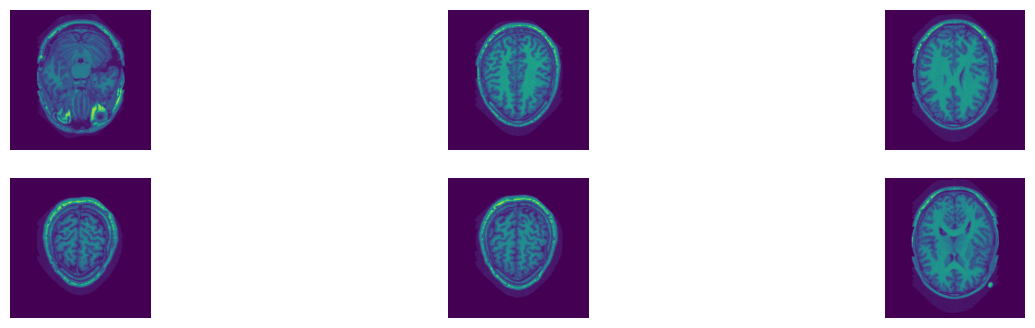

In [11]:
# Plot: t1n images
fig, axis = plt.subplots(2,3,figsize=(16,4))
for i, idx in enumerate(random_indices):
    axis[i//3,i%3].imshow((datasetTrain[idx]["gt_image"].squeeze()+1)/2)
    axis[i//3,i%3].set_axis_off()
fig.show()

### Playground for random circles

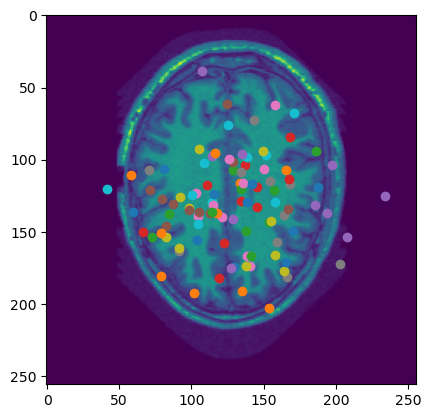

In [12]:
# visualize normal distributions of center points
centers=[]
for _ in np.arange(100):
    centers.append(torch.normal(torch.tensor([127.,127.]),torch.tensor(30.)))

plt.imshow((datasetTrain[70]["gt_image"].squeeze()+1)/2) 
for center in centers:
    plt.scatter(center[0], center[1])

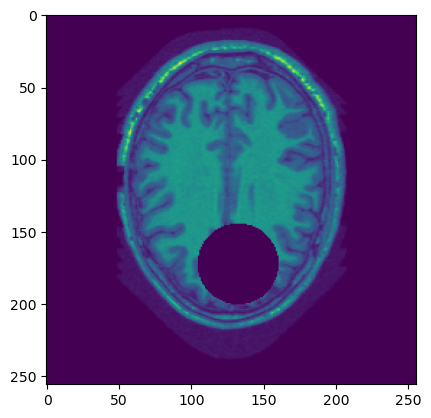

In [13]:
example=torch.zeros((10,256,256)).shape

#create circular mask with random center around the center point of the pictures and a radius between 3 and 40 pixels
center=np.random.normal([127,127],30, size=(example[0],2))
radius=np.random.uniform(low=3,high=40, size=(example[0]))

Y, X = np.ogrid[:256, :256] # gives two vectors, each containing the pixel locations. There's a column vector for the column indices and a row vector for the row indices.
dist_from_center = np.sqrt((X.T - center[:,0])[None,:,:]**2 + (Y-center[:,1])[:,None,:]**2) # creates matrix with euclidean distance to center

mask = dist_from_center <= radius # creates mask for pixels which are inside the radius
mask = 1-mask

plt.imshow(((datasetTrain[70]["gt_image"].squeeze()+1)/2)*mask[:,:,4]) 



In [14]:
#Ellips playground
"""
from math import pi

mean=torch.normal(torch.tensor([127.,127.]),torch.tensor(30.)) # mean is sampled with normal distribution around the midpoint
radius=np.random.uniform(low=3,high=50,size=(2)) # shape of ellipse is sampled with uniform distribution between 3 and 15

u=mean[0]     #x-position of the center
v=mean[1]    #y-position of the center
a=radius[0]     #radius on the x-axis
b=radius[1]    #radius on the y-axis
print(a)
print(b)

t = np.linspace(0, 2*pi, 100)
plt.plot( u+a*np.cos(t) , v+b*np.sin(t),color="red") 
plt.imshow((datasetTrain[500]["gt_image"].squeeze()+1)/2)
plt.show()
"""

'\nfrom math import pi\n\nmean=torch.normal(torch.tensor([127.,127.]),torch.tensor(30.)) # mean is sampled with normal distribution around the midpoint\nradius=np.random.uniform(low=3,high=50,size=(2)) # shape of ellipse is sampled with uniform distribution between 3 and 15\n\nu=mean[0]     #x-position of the center\nv=mean[1]    #y-position of the center\na=radius[0]     #radius on the x-axis\nb=radius[1]    #radius on the y-axis\nprint(a)\nprint(b)\n\nt = np.linspace(0, 2*pi, 100)\nplt.plot( u+a*np.cos(t) , v+b*np.sin(t),color="red") \nplt.imshow((datasetTrain[500]["gt_image"].squeeze()+1)/2)\nplt.show()\n'

### Prepare Training

In [15]:
from torch.utils.data import DataLoader

# create dataloader function, which is executed inside the training loop (necessary because of huggingface accelerate)
def get_dataloader(dataset, batch_size, shuffle):
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=4)

In [16]:
#create model
from diffusers import UNet2DModel

model = UNet2DModel(
    sample_size=config.image_size,  # the target image resolution
    in_channels=3, # the number of input channels: 1 for img, 1 for img_voided, 1 for mask
    out_channels=config.channels,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(128, 128, 256, 256, 512, 512),  # the number of output channels for each UNet block
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)

tb_summary.add_text("model", "UNet2DModel", 0) 

/opt/conda/lib/python3.11/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [17]:
#setup noise scheduler
import torch
from PIL import Image
from diffusers import DDIMScheduler

noise_scheduler = DDIMScheduler(num_train_timesteps=1000)
sample_image = datasetTrain[0]['gt_image'].unsqueeze(0)
noise = torch.randn(sample_image.shape)
timesteps = torch.LongTensor([50])
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)

tb_summary.add_text("noise_scheduler", "DDIMScheduler(num_train_timesteps=1000)", 0) 

#Image.fromarray(((noisy_image.permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[0])




In [18]:
# setup lr scheduler
from diffusers.optimization import get_cosine_schedule_with_warmup
import math

optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(math.ceil(len(datasetTrain)/config.train_batch_size) * config.num_epochs), # num_iterations per epoch * num_epochs
)

tb_summary.add_text("lr_scheduler", "cosine_schedule_with_warmup", 0) 

In [19]:
from typing import List, Optional, Tuple, Union

from diffusers import DiffusionPipeline, DDIMScheduler, ImagePipelineOutput
from diffusers.utils.torch_utils import randn_tensor



class DDIMInpaintPipeline(DiffusionPipeline):
    r"""
    Pipeline for image inpainting.

    This model inherits from [`DiffusionPipeline`]. Check the superclass documentation for the generic methods
    implemented for all pipelines (downloading, saving, running on a particular device, etc.).

    Parameters:
        unet ([`UNet2DModel`]):
            A `UNet2DModel` to denoise the encoded image latents.
        scheduler ([`SchedulerMixin`]):
            A scheduler to be used in combination with `unet` to denoise the encoded image. Can be one of
            [`DDPMScheduler`], or [`DDIMScheduler`].
    """

    model_cpu_offload_seq = "unet"

    def __init__(self, unet, scheduler):
        super().__init__()

        # make sure scheduler can always be converted to DDIM
        scheduler = DDIMScheduler.from_config(scheduler.config)

        self.register_modules(unet=unet, scheduler=scheduler)

    @torch.no_grad()
    def __call__(
        self,
        voided_imgs: torch.tensor,
        masks: torch.tensor,
        batch_size: int = 1,
        generator: Optional[Union[torch.Generator, List[torch.Generator]]] = None,
        eta: float = 0.0,
        num_inference_steps: int = 50,
        use_clipped_model_output: Optional[bool] = None,
        output_type: Optional[str] = "pil",
        return_dict: bool = True,
    ) -> Union[ImagePipelineOutput, Tuple]:
        r"""
        The call function to the pipeline for generation.

        Args:
            voided_imgs ('torch.tensor'): 
                Images (1 channel) which should be inpainted.
            masks ('torch.tensor'): 
                Binary masks which includes the area to inpaint.
            batch_size (`int`, *optional*, defaults to 1):
                The number of images to generate.
            generator (`torch.Generator`, *optional*):
                A [`torch.Generator`](https://pytorch.org/docs/stable/generated/torch.Generator.html) to make
                generation deterministic.
            eta (`float`, *optional*, defaults to 0.0):
                Corresponds to parameter eta (η) from the [DDIM](https://arxiv.org/abs/2010.02502) paper. Only applies
                to the [`~schedulers.DDIMScheduler`], and is ignored in other schedulers. A value of `0` corresponds to
                DDIM and `1` corresponds to DDPM.
            num_inference_steps (`int`, *optional*, defaults to 50):
                The number of denoising steps. More denoising steps usually lead to a higher quality image at the
                expense of slower inference.
            use_clipped_model_output (`bool`, *optional*, defaults to `None`):
                If `True` or `False`, see documentation for [`DDIMScheduler.step`]. If `None`, nothing is passed
                downstream to the scheduler (use `None` for schedulers which don't support this argument).
            output_type (`str`, *optional*, defaults to `"pil"`):
                The output format of the generated image. Choose between `PIL.Image` or `np.array`.
            return_dict (`bool`, *optional*, defaults to `True`):
                Whether or not to return a [`~pipelines.ImagePipelineOutput`] instead of a plain tuple.

        Returns:
            [`~pipelines.ImagePipelineOutput`] or `tuple`:
                If `return_dict` is `True`, [`~pipelines.ImagePipelineOutput`] is returned, otherwise a `tuple` is
                returned where the first element is a list with the generated images
        """

        # Sample gaussian noise to begin loop
        if isinstance(self.unet.config.sample_size, int):
            image_shape = (
                batch_size,
                self.unet.config.in_channels-2, # Minus the two channels for the mask and the img to be inpainted
                self.unet.config.sample_size,
                self.unet.config.sample_size,
            )
        else:
            image_shape = (batch_size, self.unet.config.in_channels-2, *self.unet.config.sample_size) # Minus the two channels for the mask and the img to be inpainted

        if isinstance(generator, list) and len(generator) != batch_size:
            raise ValueError(
                f"You have passed a list of generators of length {len(generator)}, but requested an effective batch"
                f" size of {batch_size}. Make sure the batch size matches the length of the generators."
            )

        image = randn_tensor(image_shape, generator=generator, device=self._execution_device, dtype=self.unet.dtype)

        # set step values
        self.scheduler.set_timesteps(num_inference_steps)

        #Input to unet model is concatenation of images, voided images and masks
        input=torch.cat((image, voided_imgs, masks), dim=1)

        for t in self.progress_bar(self.scheduler.timesteps):
            # 1. predict noise model_output
            model_output = self.unet(input, t).sample

            # 2. predict previous mean of image x_t-1 and add variance depending on eta
            # eta corresponds to η in paper and should be between [0, 1]
            # do x_t -> x_t-1
            image = self.scheduler.step(
                model_output, t, image, eta=eta, use_clipped_model_output=use_clipped_model_output, generator=generator
            ).prev_sample

            #3. Concatenate image with voided images and masks
            input=torch.cat((image, voided_imgs, masks), dim=1)

        image = (image / 2 + 0.5).clamp(0, 1)
        image = image.cpu().permute(0, 2, 3, 1).numpy()
        if output_type == "pil":
            image = self.numpy_to_pil(image)

        if not return_dict:
            return (image,)

        return ImagePipelineOutput(images=image)

In [20]:
def generate_masks(n, device, generator=None):
    #create circular mask with random center around the center point of the pictures and a radius between 3 and 50 pixels
    center=torch.normal(mean=config.image_size/2, std=30, size=(n,2), generator=generator, device=device) # 30 is chosen by inspection
    low=3   
    high=50
    radius=torch.rand(n, device=device, generator=generator)*(high-low)+low # get radius between 3 and 50 from uniform distribution 

    #Test case
    #center=torch.tensor([[0,255],[0,255]]) 
    #radius=torch.tensor([2,2])
    
    Y, X = [torch.arange(config.image_size, device=device)[:,None],torch.arange(config.image_size, device=device)[None,:]] # gives two vectors, each containing the pixel locations. There's a column vector for the column indices and a row vector for the row indices.
    dist_from_center = torch.sqrt((X.T - center[:,0])[None,:,:]**2 + (Y-center[:,1])[:,None,:]**2) # creates matrix with euclidean distance to center
    dist_from_center = dist_from_center.permute(2,0,1) 

    #Test case
    #print(dist_from_center[0,0,0]) #=255
    #print(dist_from_center[0,0,255]) #=360.624
    #print(dist_from_center[0,255,0]) #=0
    #print(dist_from_center[0,255,255]) #=255
    #print(dist_from_center[0,127,127]) #=180.313 
    
    masks = dist_from_center > radius[:,None,None] # creates mask for pixels which are outside the radius. 
    masks = masks[:,None,:,:].int() 
    return masks

In [21]:
#setup evaluation
from diffusers.utils import make_image_grid
from torchvision.transforms.functional import to_pil_image
import os

def evaluate(config, epoch, pipeline, eval_dataloader):
    batch = next(iter(eval_dataloader)) #TODO: Anpassen, falls grösseres evaluation set. Evt. anpassen für accelerate.
    clean_images = batch["gt_image"]

    generator = torch.cuda.manual_seed_all(config.seed)

    masks = generate_masks(n=clean_images.shape[0], generator=generator, device=clean_images.device)

    voided_images = clean_images*masks 

    images = pipeline(
        voided_images,
        masks,
        batch_size=config.eval_batch_size,
        generator=torch.manual_seed_all(config.seed),
    ).images

    # Make a grid out of the images
    image_grid = make_image_grid(images, rows=int(config.eval_batch_size**0.5), cols=int(config.eval_batch_size**0.5))

    # Save the images
    test_dir = os.path.join(config.output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/inpainted_image_{epoch:04d}.png")
    
    pil_voided_images = [to_pil_image((x+1)/2) for x in voided_images]
    voided_image_grid = make_image_grid(pil_voided_images, rows=int(config.eval_batch_size**0.5), cols=int(config.eval_batch_size**0.5))
    voided_image_grid.save(f"{test_dir}/voided_image_{epoch:04d}.png")
    
    print("image saved")

#TODO: As soon as I evaluate metrics I need to adjust the evaluate function to accelerate

In [1]:
#from accelerate import Accelerator
from accelerate import Accelerator
from huggingface_hub import create_repo, upload_folder
from tqdm.auto import tqdm
from pathlib import Path
import os 
import torch.nn as nn 
import torch.nn.functional as F
import sys
import time

def train_loop(config, model, noise_scheduler, optimizer, lr_scheduler):
    # setup training environment
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps, 
        log_with="tensorboard",
        project_dir=os.path.join(config.output_dir, "tensorboard"),
    )

    if accelerator.is_main_process:
        if config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True) 
        accelerator.init_trackers("train_example")

    train_dataloader = get_dataloader(dataset = datasetTrain, batch_size = config.train_batch_size, shuffle=True) 
    eval_dataloader = get_dataloader(dataset = datasetEvaluation, batch_size = config.eval_batch_size, shuffle=False) 

    model, optimizer, train_dataloader, eval_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, eval_dataloader, lr_scheduler
    )
    
    os.makedirs(config.output_dir, exist_ok=True)  

    global_step = 0

    #eval test case
    #epoch=0
    #model.eval()
    #pipeline = DDIMInpaintPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)  
    #evaluate(config, epoch, pipeline, eval_dataloader)
    
    
    # Train model
    model.train()
    for epoch in range(config.num_epochs): 
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process) 
        progress_bar.set_description(f"Epoch {epoch}") 
        
        for step, batch in enumerate(train_dataloader): 
            
            clean_images = batch["gt_image"]
            segmentations = batch["segm"]
            
            # Sample noise to add to the images
            noise = torch.randn(clean_images.shape, device=clean_images.device)
            bs = clean_images.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps, (bs,), device=clean_images.device,
                dtype=torch.int64
            )

            #create mask for each img
            masks = generate_masks(n = clean_images.shape[0], device=clean_images.device)
            
            #create voided img
            voided_images = clean_images*masks

            # Add noise to the voided images according to the noise magnitude at each timestep (forward diffusion process)
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps) 

            # concatenate noisy_images, voided_images and mask
            input=torch.cat((noisy_images, voided_images, masks), dim=1)

            with accelerator.accumulate(model):
                # Predict the noise residual
                noise_pred = model(input, timesteps, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)
                accelerator.clip_grad_norm_(model.parameters(), 1.0)
    
                #log gradient norm 
                parameters = [p for p in model.parameters() if p.grad is not None and p.requires_grad]
                if len(parameters) == 0:
                    total_norm = 0.0
                else: 
                    total_norm = torch.norm(torch.stack([torch.norm(p.grad.detach()).cpu() for p in parameters]), 2.0).item()

                #do learning step
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            progress_bar.update(1)

            # save logs
            if accelerator.is_main_process:
                logs = {"loss": loss.cpu().detach().item(), "lr": lr_scheduler.get_last_lr()[0], "total_norm": total_norm, "step": global_step}
                tb_summary.add_scalar("loss", logs["loss"], global_step)
                tb_summary.add_scalar("lr", logs["lr"], global_step) 
                tb_summary.add_scalar("total_norm", logs["total_norm"], global_step) 
            
                progress_bar.set_postfix(**logs)
                #accelerator.log(logs, step=global_step)
            global_step += 1 

        # After a certain number of epochs it samples some images with evaluate() and save the model
        if accelerator.is_main_process:
            model.eval()
            pipeline = DDIMInpaintPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler) 
    
            if (epoch) % config.evaluate_epochs == 0 or epoch == config.num_epochs - 1:
                evaluate(config, epoch, pipeline, eval_dataloader)
    
            if (epoch) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1: 
                pipeline.save_pretrained(config.output_dir)

tb_summary.add_text("inference_pipeline", "DDIMPipeline", 0) 

NameError: name 'tb_summary' is not defined

In [ ]:
from accelerate import notebook_launcher

# If run from a jupyter notebook then uncomment the two lines and remove last line
args = (config, model, noise_scheduler, optimizer, lr_scheduler)
#notebook_launcher(train_loop, args, num_processes=config.num_gpu)
#notebook_launcher(train_loop, args, num_processes=1)

train_loop(config, model, noise_scheduler, optimizer, lr_scheduler)

In [ ]:
#create python script for ubelix
!jupyter nbconvert --to script "lesion_filling_conditioned_circles.ipynb"
filename="lesion_filling_conditioned_circles.py"

# delete this cell from python file
lines = []
with open(filename, 'r') as fp:
    lines = fp.readlines()
with open(filename, 'w') as fp:
    for number, line in enumerate(lines):
        if number < len(lines)-17: 
            fp.write(line)